In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from ament_index_python.packages import get_package_share_directory
import yaml
from matplotlib import cm # for a scatter plot
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})

# flag the boolean 'in_project' depending on where you are running the notebook:
# - True: running the script in the ROS 2 project, the 'data' folder to render is in the 'install' one; 
# - False: the 'data' folder to use is in the same directory of the jupyter script
in_project = True

In [2]:
## read config data from file
file_data = None
package_path = None

if in_project:
    package_path = get_package_share_directory('controller')
    config_file_path = os.path.join(
        package_path,
        'config',
        'tester.yaml'
    )
    with open(config_file_path, 'r') as file: 
        file_data = yaml.safe_load(file)
else:
    with open('tester.yaml', 'r') as file: 
        file_data = yaml.safe_load(file)
    
config = file_data['tester']['ros__parameters']

# settings for tested scenarios
formulations = config['formulations']
integrations = config['integrations']
delays = config['delays']
tasks_folder = config['tasks_folder']

# read tasks data from file
tasks = None

if in_project:
    tasks_folder_path = os.path.join(
        package_path,
        tasks_folder,
    )
else:
    tasks_folder_path = tasks_folder


tasks = [{'file_name': f} for f in os.listdir(tasks_folder_path) if f.endswith('.yaml')]
tasks.sort(key=lambda x: x['file_name'])

for task in tasks:
    task['code'] = task['file_name'].split('.')[0]
    task_file_path = os.path.join(tasks_folder_path, task['file_name'])

    with open(task_file_path, 'r') as task_file:
        task['data'] = yaml.safe_load(task_file)['task']['ros__parameters']
    
# usefull staff
status_labels = ["Interrupted", "Collided", "Unsafe", "Safe"]

# debug
#### print(config)
#### print(tasks)

PackageNotFoundError: "package 'controller' not found, searching: ['/home/periot/ws/install/iq_sim', '/home/periot/ws/install/iq_gnc', '/opt/ros/humble']"

### Notes
The following code assumes the data to plot has been collected testing the controller with different delays for different tasks. The tasks are the same for every delay type. 
The control algorithm formulation is the one proposed with the thesis, namely Model Predictive Control (MPC) with safety constraints defined as Optimal Decay Robust Control Barrier Functions (ODRCBFS).
It is also assumed that the type of integration tested is just the prediction over the optimization delay, as it has been the one better performing during the research for the thesis.
The horizon length is 10, while the gamma factor for the CBFs is 0.5. 

In [ ]:
formulation = formulations[0]
integration = integrations[0]
cbf_factor = config['params'][formulation]['cbf_factors'][0]

In [ ]:
# get data folder path
data_folder_name = 'data'
test_folder_path = ''

if in_project:
    data_folder_path = os.path.join(package_path, data_folder_name)
    test_folders_list = os.listdir(data_folder_path)
    test_folders_list.sort()
    # with -1 it goes for the last one
    test_folder_path = os.path.join(data_folder_path, test_folders_list[-1])
else:
    test_folder_path = data_folder_name

# debug
print(test_folder_path)

/home/errepci/ws_ur5/install/controller/share/controller/data/20230720173900_test


In [ ]:
# read the data
data = {}
# mpc_odrcbf-prediction-constant_200-0.5

for i, delay in enumerate(delays):
    # in this case, not necessary to store the information specifying all the settings
    data[delay] = {}
    
    # however, the entire setting is required to read the data from the folder
    setting = '%s-%s-%s-%s' % (formulation, integration, delay, str(cbf_factor))

    for j, task in enumerate(tasks):
        task_code = task['code']
        
        data[delay][task_code] = {}
        
        # reconstruct the folder name containing the data of the test
        folder_path = os.path.join(test_folder_path, setting, task_code)
        
        ## read test data
        # collision.txt # not considered on the real case
        # try:
        #    with open(os.path.join(folder_path, 'collision.txt'), 'r') as file:
        #        collision = 1 if eval(file.readline().strip())  else 0
        #        data[delay][task_code]['collision'] = collision
        #        file.close()
        # except Exception as e:
        #    data[delay][task_code]['collision'] = 0
        #    print("Exception when reading collision.txt with %s and %s" % (delay, task_code))
        #    print(e)
            
        # first_solve_time.txt
        try:
            with open(os.path.join(folder_path, 'first_solve_time.txt'), 'r') as file:
                first_solve_time = float(file.readline().strip())
                data[delay][task_code]['first_solve_time'] = first_solve_time
                file.close()
        except Exception as e:
            data[delay][task_code]['first_solve_time'] = 0.0
            print("Exception when reading first_solve_time.txt with %s and %s" % (delay, task_code))
            print(e)
           
        # interruption.txt
        try:
            with open(os.path.join(folder_path, 'interruption.txt'), 'r') as file:
                interruption = 1 if eval(file.readline().strip()) else 0 
                data[delay][task_code]['interruption'] = interruption
                file.close()
        except:
            interruption = 0
            data[delay][task_code]['interruption'] = interruption
            print("Exception when reading interruption.txt with %s and %s" % (delay, task_code))
            
        # safety.txt
        try:
            with open(os.path.join(folder_path, 'safety.txt'), 'r') as file:
                safety = 1 if eval(file.readline().strip()) else 0
                data[delay][task_code]['safety'] = safety
                file.close()
        except Exception as e:
            data[delay][task_code]['safety'] = 0
            print("Exception when reading safety.txt with %s and %s" % (delay, task_code))
            print(e)
                
                
        # read the following quantities only if the test has not been interrupted
        # it doesn't make sense to read "totals" if the test didn't finish
        if interruption == 0:
            # delay_values.txt
            try:
                with open(os.path.join(folder_path, 'delay_values.txt'), 'r') as file:
                    delay_values = np.loadtxt(file)
                    i = np.where(np.isnan(delay_values[:, 0]))[0][0]
                    data[delay][task_code]['delay_values'] = delay_values[:i]
                    file.close()  
            except Exception as e:
                data[delay][task_code]['delay_values'] = None
                print("Exception when reading delay_values.txt with %s and %s" % (delay, task_code))
                print(e)
        
            # state_values.txt
            try:
                with open(os.path.join(folder_path, 'state_values.txt'), 'r') as file:
                    state_values = np.loadtxt(file)
                    i = np.where(np.isnan(state_values[:,0]))[0][0]
                    data[delay][task_code]['state_values'] = state_values[:i]
                    file.close()
            except Exception as e:
                data[delay][task_code]['state_values'] = None
                print("Exception when reading state_values.txt with %s and %s" % (delay, task_code))
                print(e)
            
            # input_values.txt
            try:
                with open(os.path.join(folder_path, 'input_values.txt'), 'r') as file:
                    input_values = np.loadtxt(file)
                    i = np.where(np.isnan(input_values[:, 0]))[0][0]
                    data[delay][task_code]['input_values'] = input_values[:i]
                    file.close()
            except Exception as e:
                data[delay][task_code]['input_values'] = None
                print("Exception when reading input_values.txt with %s and %s" % (delay, task_code))
                print(e)
             
            # obstacles_distance.txt                
            try:
                with open(os.path.join(folder_path, 'obstacles_distance.txt'), 'r') as file:
                    obstacles_distance = np.loadtxt(file)
                    i = np.where(np.isnan(obstacles_distance[:, 0]))[0][0]
                    data[delay][task_code]['obstacles_distance'] = obstacles_distance[:i]
                    file.close()
            except Exception as e:
                data[delay][task_code]['obstacles_distance'] = None
                print("Exception when reading obstacles_distance.txt with %s and %s" % (delay, task_code))
                print(e)
                     
            
            # total_distance.txt
            try:
                with open(os.path.join(folder_path, 'total_distance.txt'), 'r') as file:
                    total_distance = float(file.readline().strip())
                    data[delay][task_code]['total_distance'] = total_distance
                    file.close()
            except Exception as e:
                data[delay][task_code]['total_distance'] = 0.0
                print("Exception when reading total_distance.txt with %s and %s" % (delay, task_code))
                print(e)

            # total_time.txt
            try:
                with open(os.path.join(folder_path, 'total_time.txt'), 'r') as file:
                    total_time = float(file.readline().strip())
                    data[delay][task_code]['total_time'] = total_time
                    file.close()
            except Exception as e:
                data[delay][task_code]['total_time'] = 0.0
                print("Exception when reading total_time.txt with %s and %s" % (delay, task_code))
                print(e)
        else:
            data[delay][task_code]['delay_values'] = None
            data[delay][task_code]['state_values'] = None
            data[delay][task_code]['input_values'] = None
            data[delay][task_code]['obstacles_distance'] = None
            data[delay][task_code]['total_distance'] = 0.0
            data[delay][task_code]['total_time'] = 0.0
            
# debug
# print(data)

### Notes
The following blocks plot a certain metric or aspect of the collected data.
1. Test status and totals.
2. Projection of the path travelled by the system (a) 3D, (b) 2D and (c) select one test and mantain the scale in 2D.
3. Minimum distance from the obstacles while performing the task.

The variables below are named following what just stated.

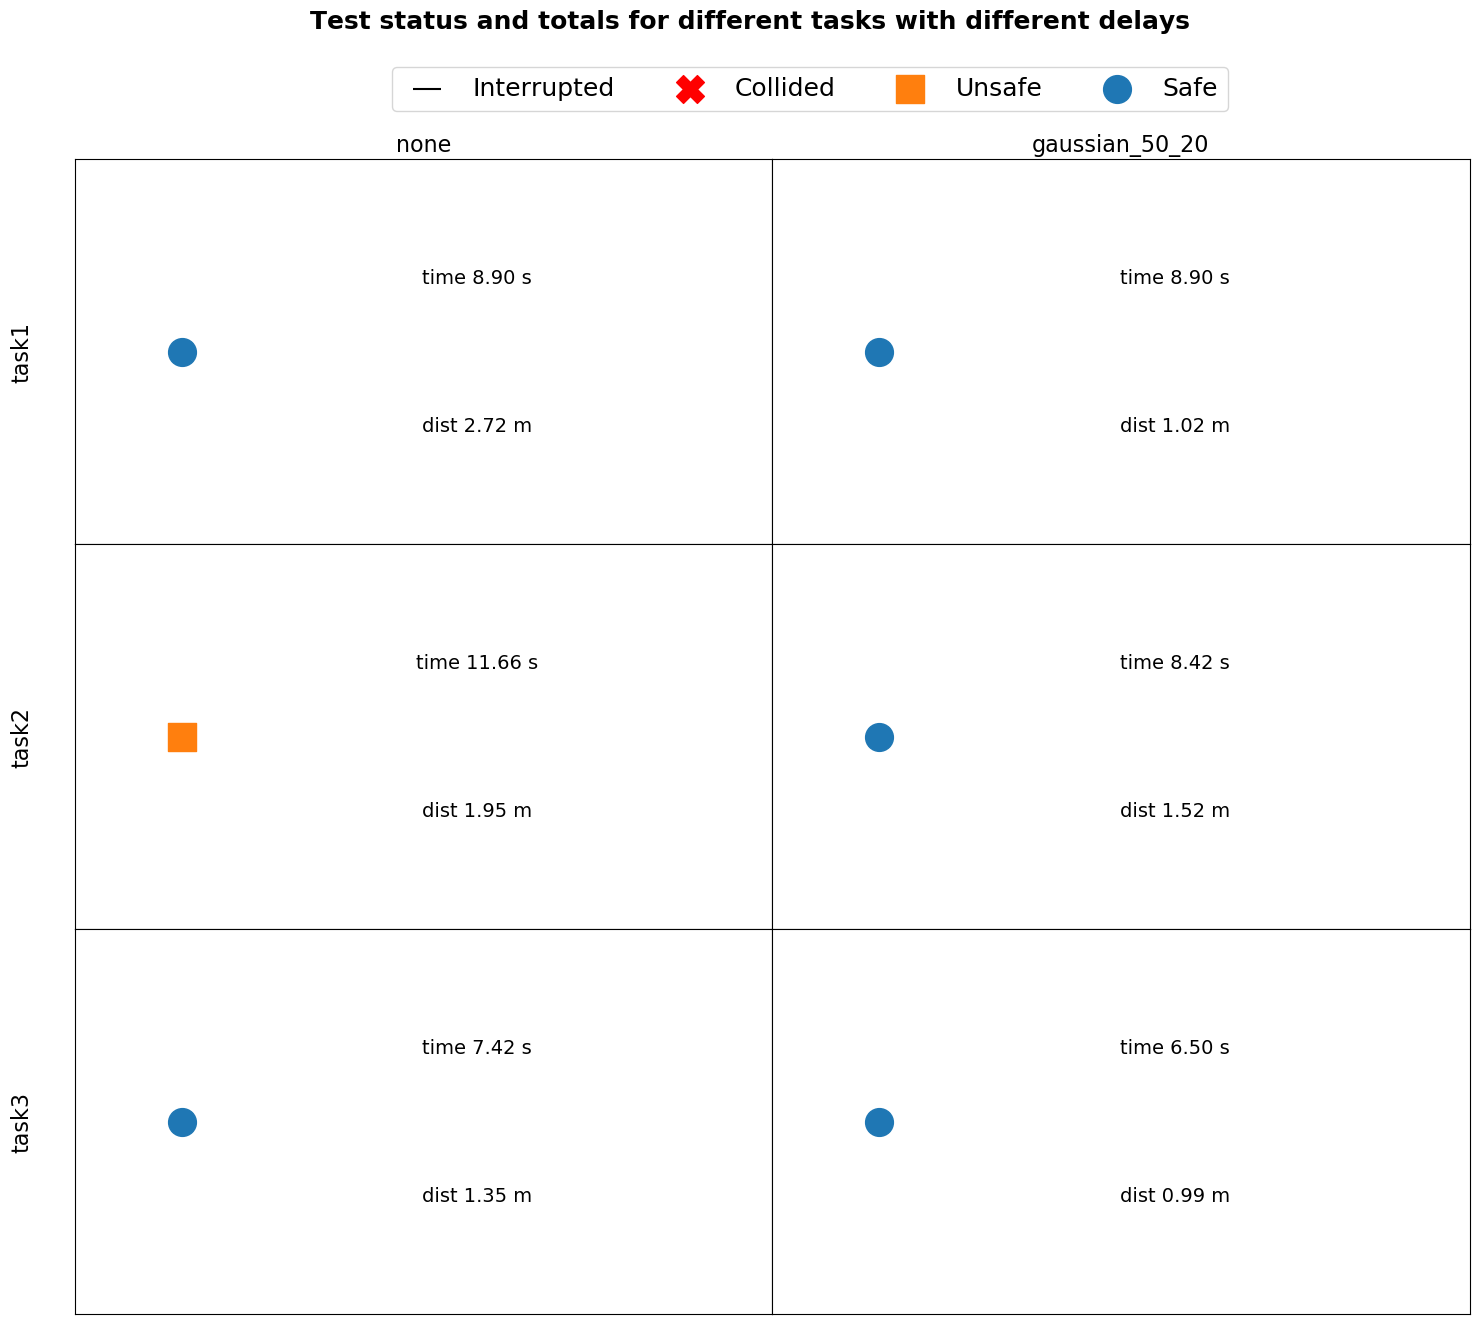

In [ ]:
# 1. Qualitative comparison on the tests' status (Interrupted, Collided, Unsafe, Safe)
fig_1_table, axs_1_table = plt.subplots(nrows=len(tasks), ncols=len(delays), figsize=(18, 15))

for j, delay in enumerate(delays):
    axs_1_table[0, j].set_title(delay, fontsize=16)
    
    for i, task in enumerate(tasks):
        
        task_code = task['code']
        axs_1_table[i, 0].set_ylabel(task_code, fontsize=16)
        axs_1_table[i, 0].yaxis.labelpad=30
        
        symbol = None

        if data[delay][task_code]["interruption"]:
            symbol = ('_','k')
        # not considered in the real case
        # elif data[delay][task_code]["collision"]: 
        #    symbol = ('X','r')
        elif data[delay][task_code]["safety"]: 
            symbol = ('o','C0')
        else:
            # unsafe, but not collided
            symbol = ('s','C1')
        
        total_time = data[delay][task_code]["total_time"]
        total_distance = data[delay][task_code]["total_distance"]

        axs_1_table[i, j].scatter(-0.4, 0.5, marker=symbol[0], color=symbol[1], s=400)
        axs_1_table[i, j].text(0.7, 1, "time {:.2f} s".format(total_time), ha='center', va='center', fontsize=14)
        axs_1_table[i, j].text(0.7, 0, "dist {:.2f} m".format(total_distance), ha='center', va='center',fontsize=14)

        axs_1_table[i, j].set_xlim(-0.8, 2 - 0.2)
        axs_1_table[i, j].set_ylim(-0.8, 2 - 0.2)
        axs_1_table[i, j].set_xticks([])
        axs_1_table[i, j].set_yticks([])
        
# Set the title of the chart
interrupted_symbol = axs_1_table[0, 0].scatter([], [], s=400, marker='_', color='k')
collided_symbol = axs_1_table[0, 0].scatter([], [], s=400, marker='X', color='r')
unsafe_symbol = axs_1_table[0, 0].scatter([], [], s=400, marker='s', color='C1')
safe_symbol = axs_1_table[0, 0].scatter([], [], s=400, marker='o', color='C0')

comparison_legend = [interrupted_symbol, collided_symbol, unsafe_symbol, safe_symbol]

fig_1_table.legend(
    comparison_legend, 
    status_labels, 
    loc='upper center',  
    ncol=4, 
    fontsize=18,
    bbox_to_anchor=(0.45, 0.85)
)
fig_1_title = "Test status and totals for different tasks with different delays"
fig_1_table.suptitle(fig_1_title, fontsize=18, fontweight='bold')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
# 2.
# a) 3D plot of the path and the environment

In [ ]:
def plot_sphere(ax, pos, r, color):
    u, v = np.linspace(0, 2 * np.pi, 50), np.linspace(0, np.pi, 50)
    x = r*np.outer(np.cos(u), np.sin(v))
    y = r*np.outer(np.sin(u), np.sin(v))
    z = r*np.outer(np.ones(np.size(u)), np.cos(v))
    
    ax.plot_surface(pos[0]+x, pos[1]+y, pos[2]+z, color=color)
    
# debug
### fig_sphere = plt.figure(1)
### ax_sphere = fig_sphere.add_subplot(projection='3d')
### plot_sphere(ax_sphere, [1,1,1], 1, 'r')

In [ ]:
def plot_3D(xmin, xmax, ymin, ymax, zmin, zmax):
    fig_2_plot, axs_2_plot = plt.subplots(nrows=len(tasks), ncols=len(delays), figsize=(20, 15), subplot_kw={'projection': '3d'})

    for j, delay in enumerate(delays):
        axs_2_plot[0, j].set_title(delay, fontsize=16)
 
        for i, task in enumerate(tasks):
 
            task_code = task['code']

            axs_2_plot[i, j].set_xlim(xmin, xmax)
            axs_2_plot[i, j].set_ylim(ymin, ymax)
            axs_2_plot[i, j].set_zlim(zmin, zmax)

            axs_2_plot[i, j].set_xlabel('x [m]')
            axs_2_plot[i, j].set_ylabel('y [m]')
            axs_2_plot[i, j].set_zlabel('z [m]')
            
            state_values = data[delay][task_code]["state_values"]
            if state_values is not None:
                axs_2_plot[i, j].plot(state_values[:,1], state_values[:,2], state_values[:,3])
        
            # add obstacles
            for obs in task['data']['obstacles']:
                plot_sphere(axs_2_plot[i, j], obs['pos'], obs['r'], 'r')

            # add target points
            for point in task['data']['target_points']:
                plot_sphere(axs_2_plot[i, j], point['pos'], 0.01, 'y')
            
            print('Delay %s, %s done' % (delay, task_code))

    # legend and title of the image
    fig_2_title = "3D plot of the path and the environment" 
    fig_2_plot.suptitle(fig_2_title, fontsize=18, fontweight='bold')

    plt.show() # to avoid printing the title

Delay none, task1 done
Delay none, task2 done
Delay none, task3 done
Delay gaussian_50_20, task1 done
Delay gaussian_50_20, task2 done
Delay gaussian_50_20, task3 done


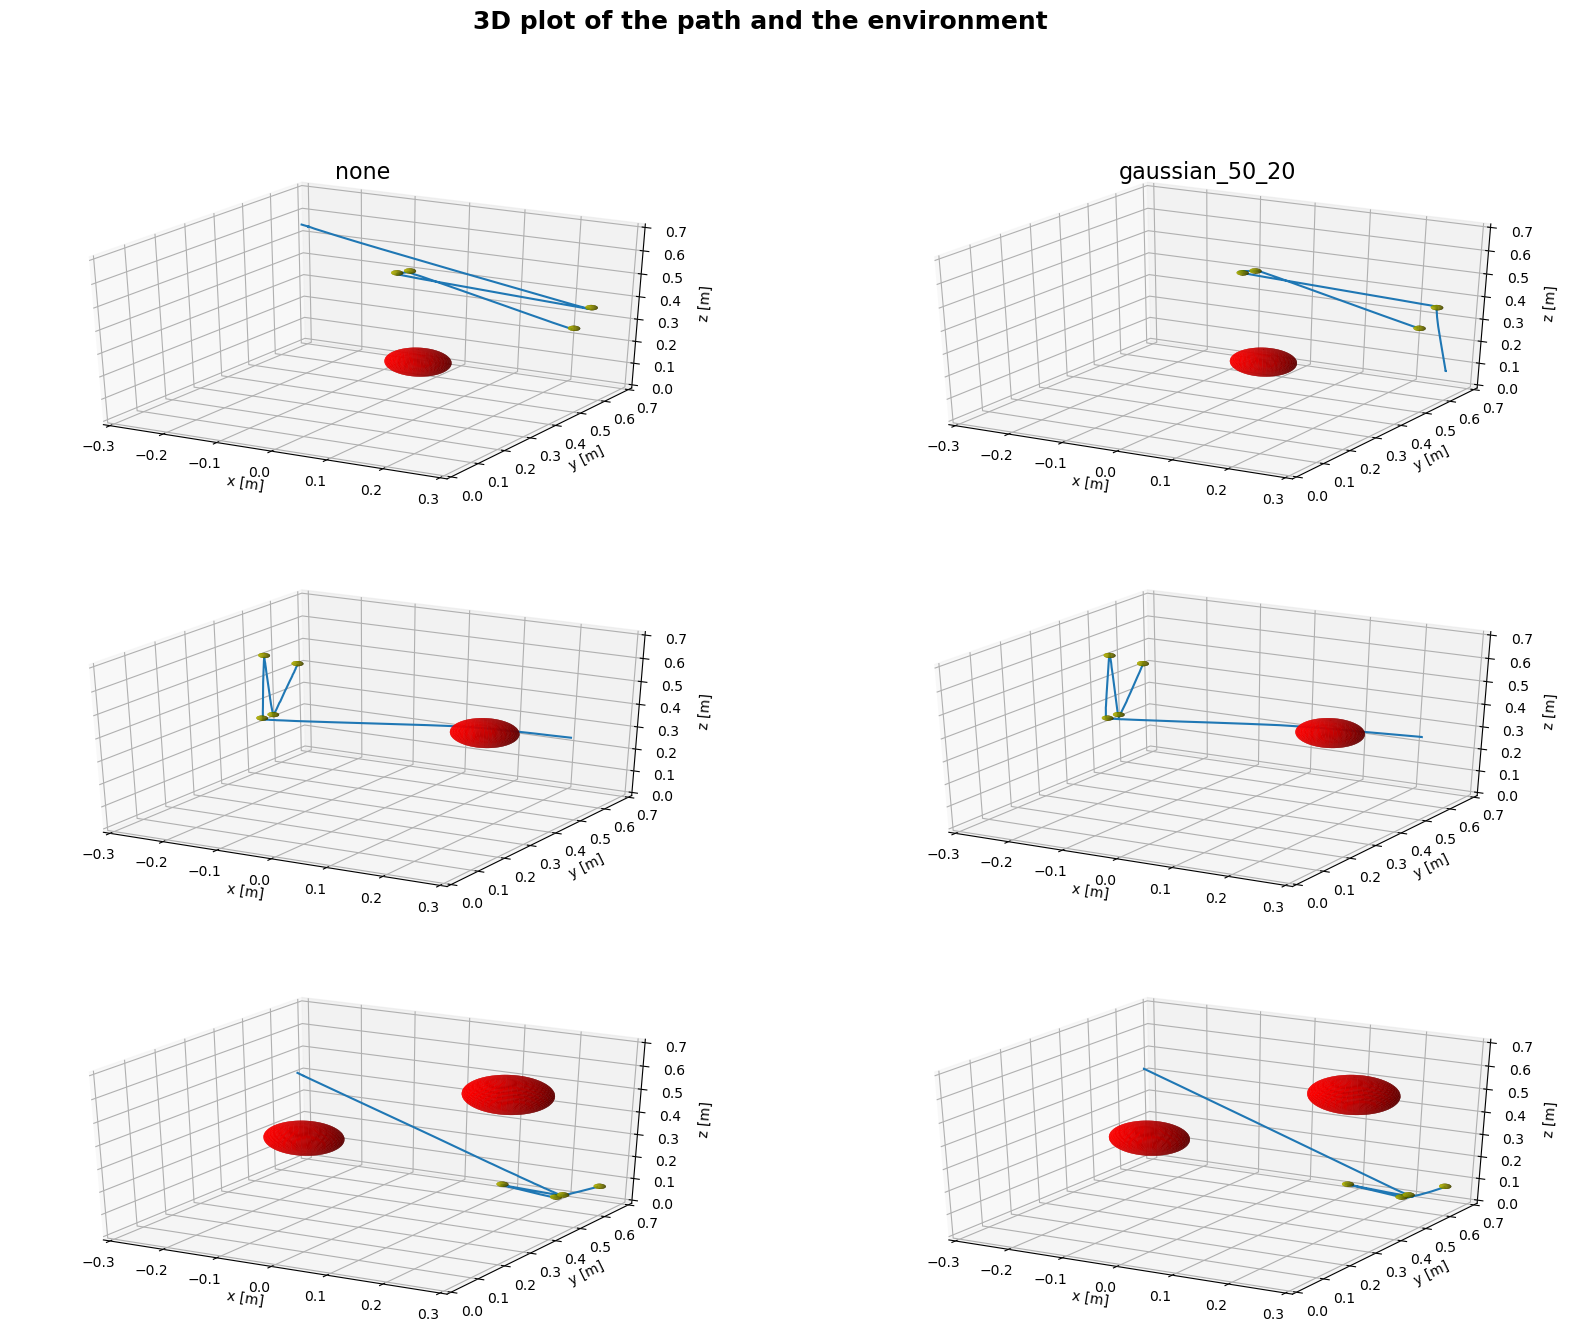

In [ ]:
plot_3D(-0.3, 0.3, 0.0, 0.7, 0.0, 0.7)

In [ ]:
# b) 2D plot of the path and the environment
# y is fixed to 0 both for the obstacles, the target points and the plots

In [ ]:
def plot_circle(ax, pos, r, color, fill=True):
    # whatch out! We are projecting the path on the y-plane
    # the circle coordinates we need to use are the first and the last (i.e. x and z)
    circle = plt.Circle((pos[0], pos[2]), r, color=color, fill=fill)
    ax.add_patch(circle)
    
# debug
### fig_circle = plt.figure(1)
### ax_circle = fig_circle.add_subplot()
### plot_circle(ax_circle, [1,1,1], 1, 'r')

In [ ]:
def plot_2D(xmin, xmax, zmin, zmax):
    # whatch out! We are projecting the path on the y-plane
    # the z coordinates are projected on the y-axis (and so are the labels and the limits)
    fig_2_plot, axs_2_plot = plt.subplots(nrows=len(tasks), ncols=len(delays), figsize=(20, 15))

    for j, delay in enumerate(delays):
 
        for i, task in enumerate(tasks):
            task_code = task['code']
            
            axs_2_plot[i, j].set_title("%s, %s" %(delay, task_code), fontsize=16)

            axs_2_plot[i, j].set_xlim(xmin, xmax)
            axs_2_plot[i, j].set_ylim(zmin, zmax)

            axs_2_plot[i, j].set_xlabel('x [m]')
            axs_2_plot[i, j].set_ylabel('z [m]')

            state_values = data[delay][task_code]["state_values"]
            if state_values is not None:
                axs_2_plot[i, j].plot(state_values[:,1], state_values[:,3])
        
            # add obstacles
            for obs in task['data']['obstacles']:
                plot_circle(axs_2_plot[i, j], obs['pos'], obs['r'], 'r')

            # add target points
            for point in task['data']['target_points']:
                plot_circle(axs_2_plot[i, j], point['pos'], 0.01, 'y')
            
            print('Delay %s, %s done' % (delay, task_code))

    # legend and title of the image
    fig_2_title = "2D projections of the path and the environment" 
    fig_2_plot.suptitle(fig_2_title, fontsize=18, fontweight='bold')

    plt.show() # to avoid printing the title

Delay none, task1 done
Delay none, task2 done
Delay none, task3 done
Delay gaussian_50_20, task1 done
Delay gaussian_50_20, task2 done
Delay gaussian_50_20, task3 done


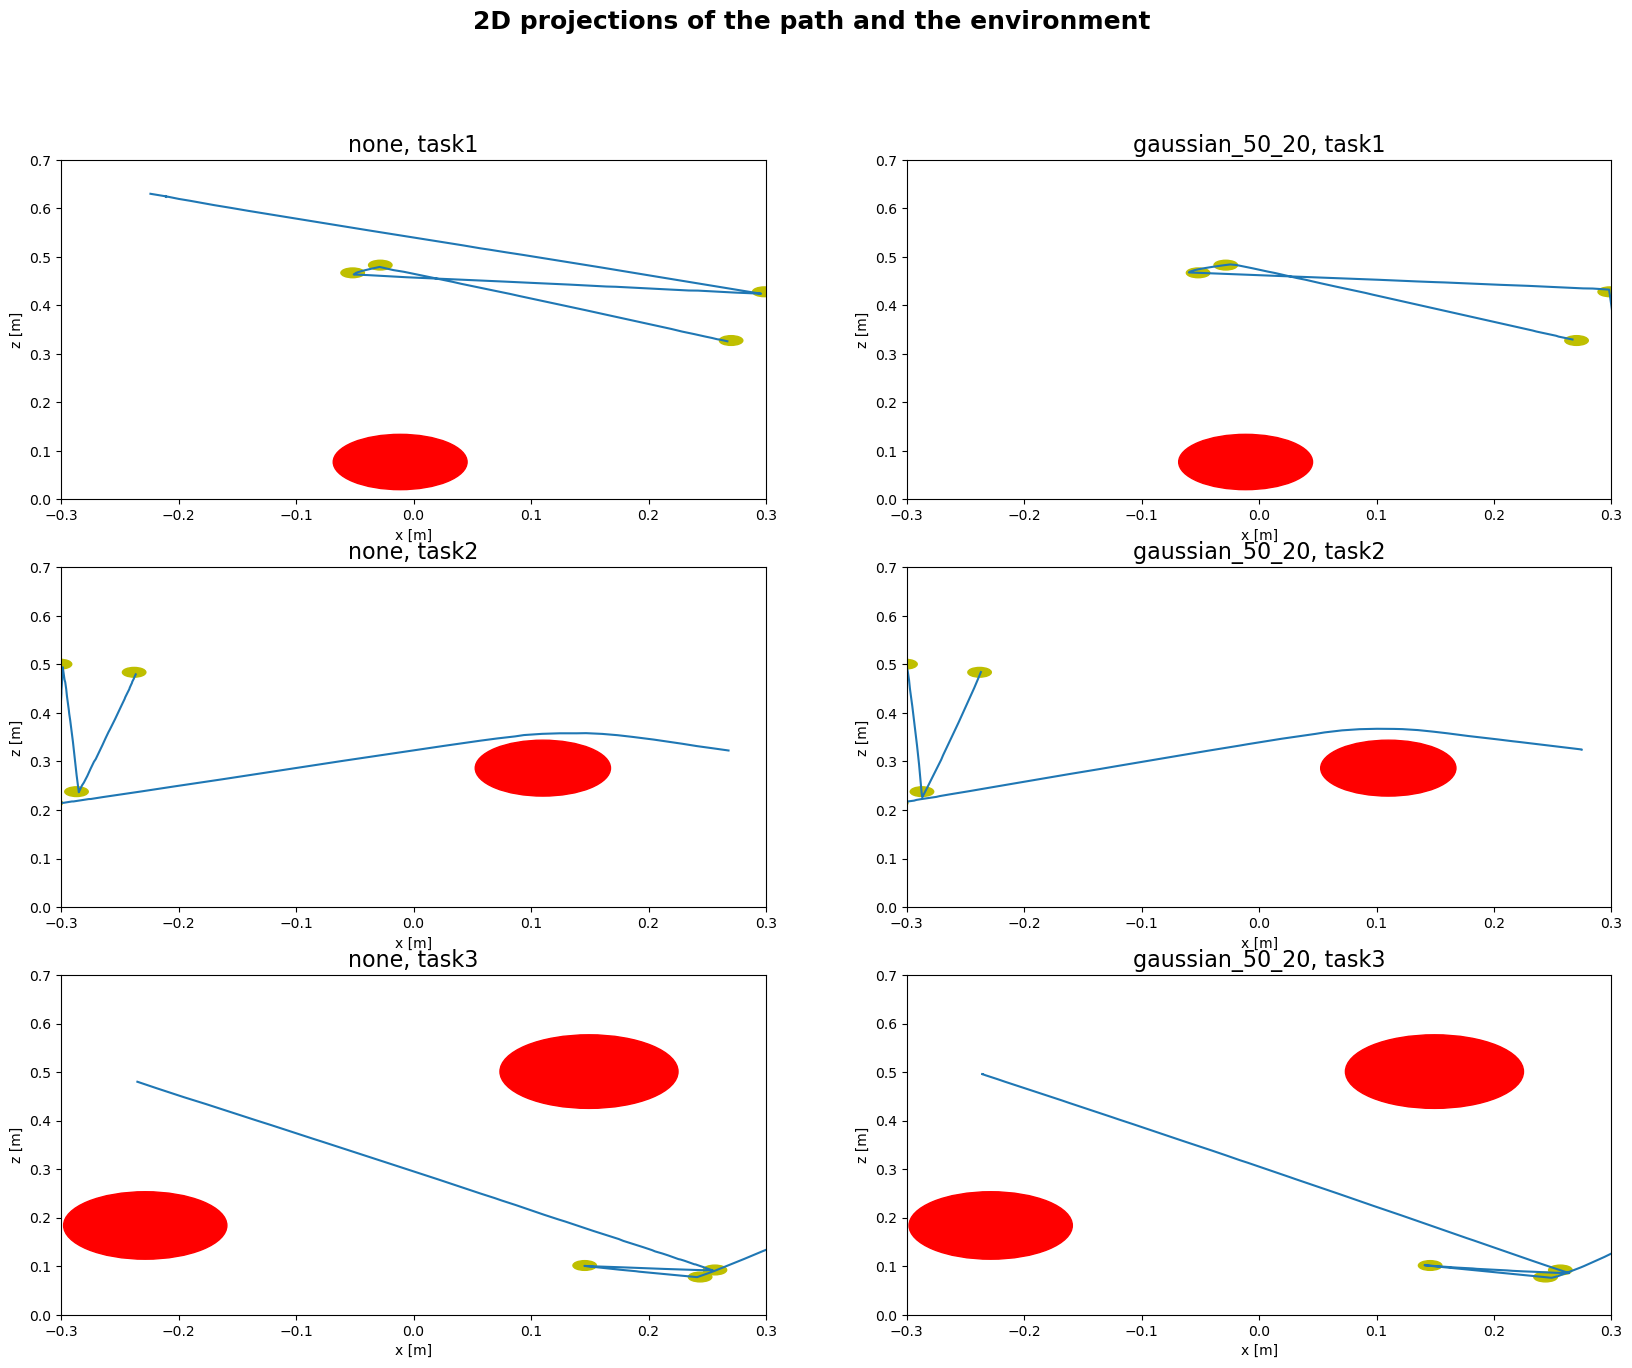

In [ ]:
plot_2D(-0.3, 0.3, 0.0, 0.7) 

In [ ]:
# c) get one specific plots from those above.
# Specify the task with its code (row number, from 1 to N) and the delay through its column (1, 2,...). 

In [ ]:
def plot_2D_target(task_number, delay_number, xmin, xmax, zmin, zmax, scaled=True, black_and_white=False):
    # whatch out! We are projecting the path on the y-plane
    # the z coordinates are projected on the y-axis (and so are the labels and the limits)
    fig_2_plot, axs_2_plot = plt.subplots()
    
    task_code = 'task%i' % task_number
    task = next((x for x in tasks if x['code'] ==task_code), None)
    # print(task)
    delay = delays[delay_number-1]
    
    axs_2_plot.set_xlim(xmin, xmax)
    axs_2_plot.set_ylim(zmin, zmax)

    axs_2_plot.set_xlabel('x [m]')
    axs_2_plot.set_ylabel('z [m]')
    if scaled:
        axs_2_plot.axis('scaled')
        
    col0, col1, col2 = '','',''
    if black_and_white:
        col0 = '#646464'
        col1 = 'k'
        col2 = '#a4a4a4'
    else:
        col0 = 'C0'
        col1 = 'r'
        col2 = 'y'
        
    
    state_values = data[delay][task_code]["state_values"]
    if state_values is not None:
        axs_2_plot.plot(state_values[:,1], state_values[:,3], color=col0)
    

    # add obstacles
    for obs in task['data']['obstacles']:
        plot_circle(axs_2_plot, obs['pos'], obs['r'], col1) 

    # add target points
    for point in task['data']['target_points']:
        plot_circle(axs_2_plot, point['pos'], 0.01, col2, False)

    # legend and title of the image
    fig_2_title = "2D projections for %s with %s delay" % (task_code, delay) 
    fig_2_plot.suptitle(fig_2_title, fontsize=18, fontweight='bold')

    plt.show() # to avoid printing the title

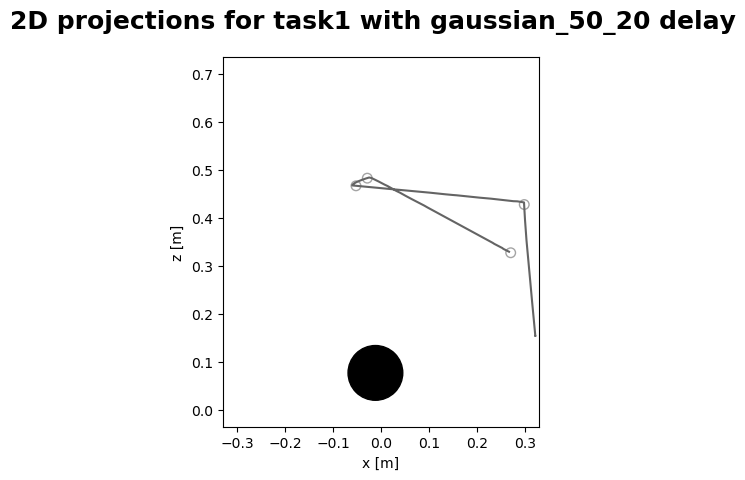

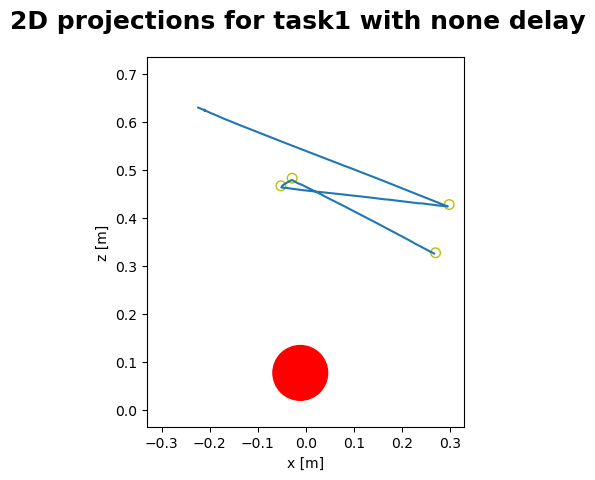

In [ ]:
task_number = 1   # pay attention, the number refers to the code, not to the index 
delay_number = 2

plot_2D_target(task_number, delay_number, -0.3, 0.3, 0.0, 0.7, scaled=True, black_and_white=True)
plot_2D_target(1, 1, -0.3, 0.3, 0.0, 0.7, scaled=True)

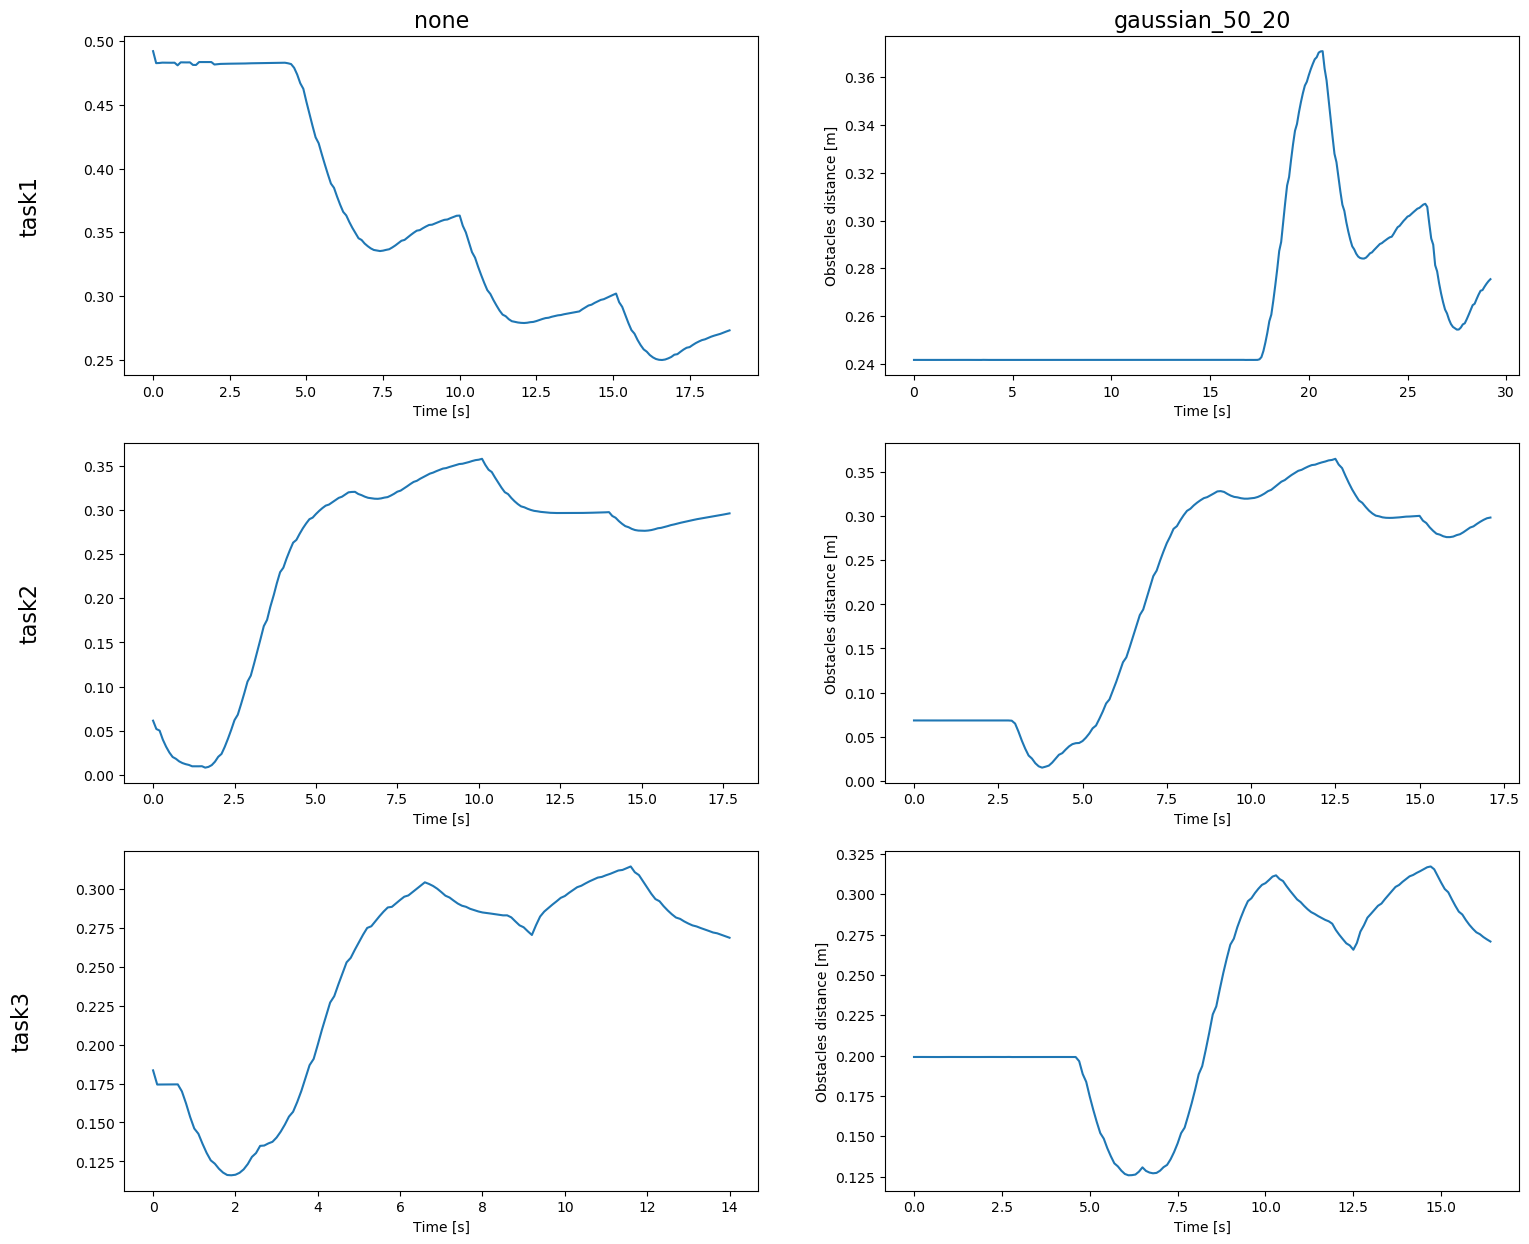

In [ ]:
# 3. obstacles distance
fig_3_plot, axs_3_plot = plt.subplots(nrows=len(tasks), ncols=len(delays), figsize=(18, 15))

for j, delay in enumerate(delays):
    axs_3_plot[0, j].set_title(delay, fontsize=16)
    
    for i, task in enumerate(tasks):
        
        task_code = task['code']
        axs_3_plot[i, 0].set_ylabel(task_code, fontsize=16)
        axs_3_plot[i, 0].yaxis.labelpad=30
        
        obstacles_distance = data[delay][task_code]["obstacles_distance"]
        
        if obstacles_distance is not None:
            start_time = obstacles_distance[0,0] if obstacles_distance is not None else 0.0
            distances = np.min(obstacles_distance[:, 1:], axis=1)
            axs_3_plot[i, j].plot((obstacles_distance[:,0]-start_time), distances)
            axs_3_plot[i, j].set(xlabel="Time [s]", ylabel="Obstacles distance [m]")

Don't know what else to plot yet..